In [1]:
import pandas as pd

## Import data

In [3]:
import pandas as pd

# Specify the correct file paths
math_path = "C:/Users/linka/Downloads/student+performance/student/student-mat.csv"
por_path = "C:/Users/linka/Downloads/student+performance/student/student-por.csv"

# Load the datasets with the correct delimiter
df_math = pd.read_csv(math_path, delimiter=';')
df_por = pd.read_csv(por_path, delimiter=';')

# Check the first few rows to confirm the data is loaded correctly
print(df_math.head())
print(df_por.head())


  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     G

## One hot encode

In [5]:
# Math dataset
X_math = df_math.drop('G3', axis=1)  
y_math = df_math['G3']               

# Portuguese dataset
X_por = df_por.drop('G3', axis=1)
y_por = df_por['G3']
X_math_encoded = pd.get_dummies(X_math, drop_first=True)


X_por_encoded = pd.get_dummies(X_por, drop_first=True)


print(X_math_encoded.head())
print(X_por_encoded.head())


   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         3       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  ...  guardian_mother  guardian_other  schoolsup_yes  famsup_yes  \
0     1  ...             True           False           True       False   
1     1  ...            False           False          False        True   
2     2  ...             True           False           True       False   
3     1  ...             True           False          False        True   
4     1  ...            False           False          False        True   

   paid_yes  activities_yes  nursery_yes  higher_yes  internet

## Train test split

In [6]:
from sklearn.model_selection import train_test_split

# Math dataset split
X_train_math, X_test_math, y_train_math, y_test_math = train_test_split(X_math_encoded, y_math, test_size=0.2, random_state=42)

# Portuguese dataset split
X_train_por, X_test_por, y_train_por, y_test_por = train_test_split(X_por_encoded, y_por, test_size=0.2, random_state=42)


## Heat map for correlation

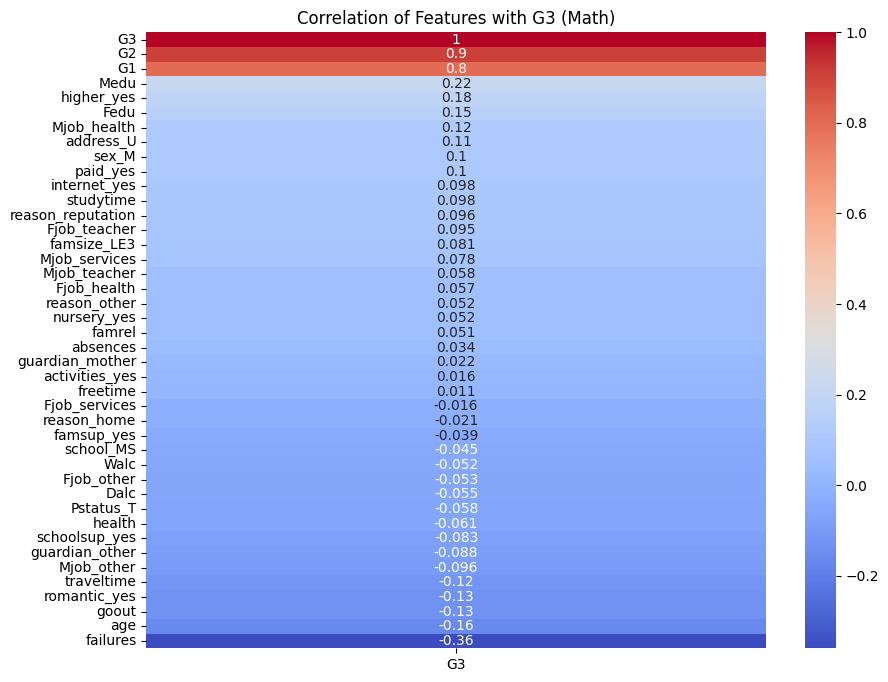

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#need to one hot encode again
df_math_encoded = pd.get_dummies(df_math, drop_first=True)

# corr calc
corr_matrix_math = df_math_encoded.corr()

# Visualize correlation with G3
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_math[['G3']].sort_values(by='G3', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with G3 (Math)')
plt.show()


## K best rfe

ranking using recursive feature elimination
Train using all of the features, then eliminate the ones that don't perform

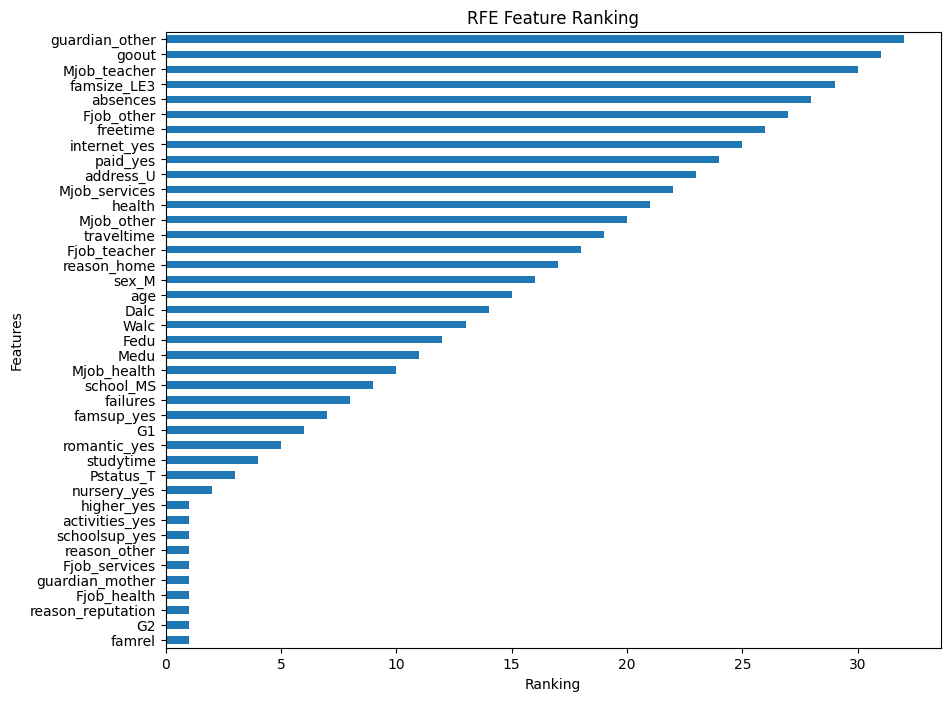

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


model = LinearRegression()

# Recursive feature elimination 
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_math_encoded, y_math)

# Get the RFE rankings
rfe_ranking = pd.Series(rfe.ranking_, index=X_math_encoded.columns)

# Sort 
rfe_ranking_sorted = rfe_ranking.sort_values()

# Plot
plt.figure(figsize=(10, 8))
rfe_ranking_sorted.plot(kind='barh')
plt.title('RFE Feature Ranking')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.show()


## K best

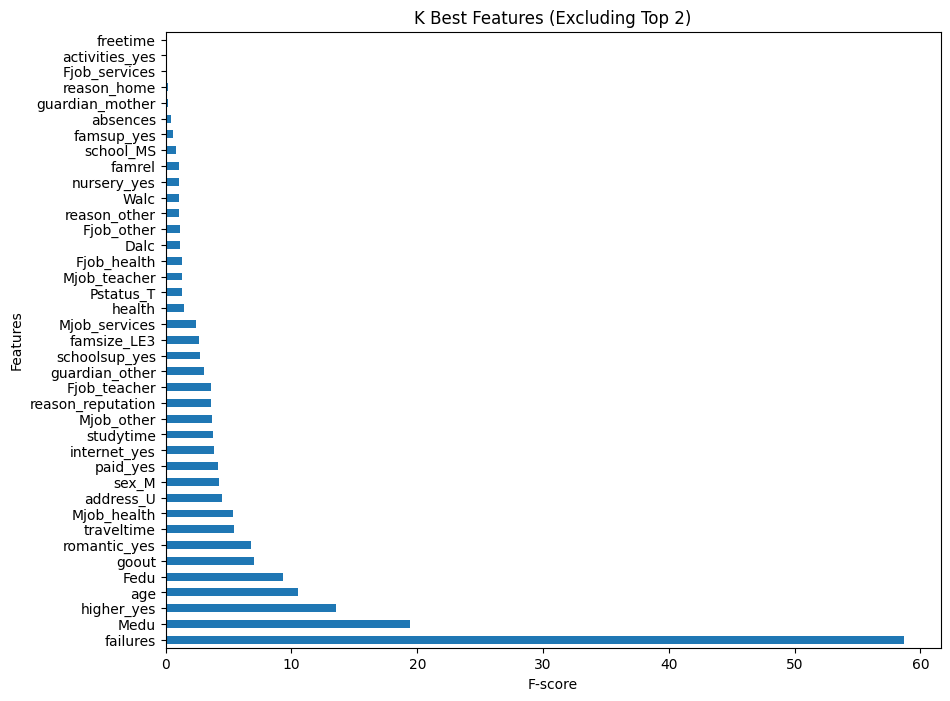

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

# want top 10
selector = SelectKBest(f_regression, k=10)
selector.fit(X_math_encoded, y_math)

# Get the scores for each feature
kbest_scores = pd.Series(selector.scores_, index=X_math_encoded.columns)

# Sort 
kbest_scores_sorted = kbest_scores.sort_values(ascending=False)

# Dont want top 2, it is going to be grades any ways
kbest_scores_excluding_top2 = kbest_scores_sorted[2:]

# Plot the scores excluding the top 2 features
plt.figure(figsize=(10, 8))
kbest_scores_excluding_top2.plot(kind='barh')
plt.title('K Best Features (Excluding Top 2)')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()


## R2 score

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd


r2_scores = {}

# Loop 
for feature in X_math_encoded.columns:
    # Reshape the feature to fit the model
    X_single_feature = X_math_encoded[[feature]]
    
    
    model = LinearRegression()
    model.fit(X_single_feature, y_math)
    
    # Predict 
    y_pred = model.predict(X_single_feature)
    
    # Calc
    r2_scores[feature] = r2_score(y_math, y_pred)

r2_scores_df = pd.DataFrame(list(r2_scores.items()), columns=['Feature', 'R2_Score'])
r2_scores_sorted = r2_scores_df.sort_values(by='R2_Score', ascending=False)

# Display the top 10
print(r2_scores_sorted.head(10))


         Feature  R2_Score
14            G2  0.818786
13            G1  0.642351
5       failures  0.129899
1           Medu  0.047153
38    higher_yes  0.033293
0            age  0.026108
2           Fedu  0.023243
8          goout  0.017634
40  romantic_yes  0.016892
3     traveltime  0.013722
